In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('../reference/jax-cosmo/jax_cosmo-master/')

In [56]:
import os 
import pickle 
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sacc
import jax
import optax
from jax import grad, jit, vmap, jacfwd, hessian
from jax import random
import jax_cosmo as jc
import pyccl as ccl
from jax.config import config
config.update("jax_enable_x64", True)

import numpyro
from numpyro.infer import init_to_feasible
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value, init_to_median
from numpyro.handlers import seed, trace, condition

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15
save_plots = False
key = random.PRNGKey(0)

In [4]:
import jax_cosmo.power as jcp 
jcp.USE_EMU = False

In [5]:
saccfile = sacc.Sacc.load_fits('../data/cls_DESY1.fits')

In [8]:
tracers_names = list(saccfile.tracers.keys())
nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])

In [9]:
jax_nz_wl = list()
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    zmax = 2.0#2.9999 # max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float64'),distribution.nz.astype('float64'), zmax = zmax)
    jax_nz_wl.append(jaxred)

In [10]:
redshifts = distribution.z.astype('float64')

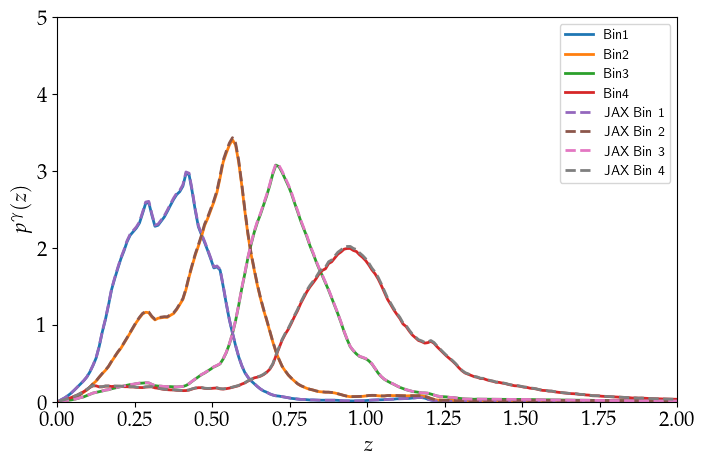

In [11]:
plt.figure(figsize=(8,5))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_wl):
    plt.plot(redshifts, jax_nz_wl[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.0)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl_jax.pdf', bbox_inches = 'tight')
plt.show()

In [12]:
def calculate_lmax_gc(sfile, kmax):
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    vanillacosmo = jc.Planck15() # ccl.CosmologyVanillaLCDM()
    lmaxs = list()
    
    for i in range(nbin_gc):
        tracer = sfile.tracers[f'DESgc__{i}']
        zmid = jnp.average(jnp.asarray(tracer.z), weights=jnp.asarray(tracer.nz))
        chi = jc.background.radial_comoving_distance(vanillacosmo, 1./(1. + zmid))
        minmax = jnp.concatenate([10.*jnp.ones(1), kmax * chi - 0.5], dtype = int)
        lmax = jnp.max(minmax)
        lmaxs.append(lmax)
    return lmaxs

In [13]:
def scale_cuts(sfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000):
    # First we remove all B-modes
    sfile.remove_selection(data_type='cl_bb')
    sfile.remove_selection(data_type='cl_be')
    sfile.remove_selection(data_type='cl_eb')
    sfile.remove_selection(data_type='cl_0b')

    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    lmaxs_gc = calculate_lmax_gc(sfile, kmax)
    
    for i, lmax in enumerate(lmaxs_gc):
        print(f'Maximum ell is {lmax}')
        tname_1 = f'DESgc__{i}'
        
        # Remove from galaxy clustering
        sfile.remove_selection(data_type='cl_00', tracers=(tname_1, tname_1), ell__gt=lmax)
        
        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_0e', tracers=(tname_1, tname_2), ell__gt=lmax)
    
    # apply scale cut for weak lensing 
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tname_1 = f'DESwl__{i}'
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__gt= lmax_wl)
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__lt= lmin_wl)
            
    return sfile, lmaxs_gc

In [14]:
saccfile_cut, lmaxs_gc = scale_cuts(saccfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000)

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


In [15]:
def interpolate(ellvalues, clvalues, newells):
    ellvalues_log = jnp.log(ellvalues)
    clvalues_log = jnp.log(clvalues)
    newells_log = jnp.log(newells)
    interpolation = jnp.interp(newells_log, ellvalues_log, clvalues_log)
    interp_final = jnp.exp(interpolation)
    return interp_final

def get_data_type(tracer_combination):
    if 'gc' in tracer_combination[0] and 'gc' in tracer_combination[1]:
        dtype = 'cl_00'
    elif 'gc' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_0e'
    elif 'wl' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_ee'
    return dtype

def get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax = 3000):
    
    dtype = get_data_type((tracer_name_1, tracer_name_2))    
    idx = sfile.indices(data_type=dtype, tracers=(tracer_name_1, tracer_name_2))
    window = sfile.get_bandpower_windows(idx)
    fine_ells = window.values
    indices = (fine_ells >= 2) & (fine_ells <= ellmax)
    fine_ells = jnp.asarray(fine_ells[indices], dtype = jnp.float32)
    bandwindow = jnp.asarray(window.weight[indices])
    return fine_ells, bandwindow

def extract_bandwindow(sfile, ellmax = 3000):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    record = []
    
    # # galaxy-galaxy 
    # for i in range(nbin_gc):
    #     tracer_name = f'DESgc__{i}'
    #     key = f'{tracer_name},{tracer_name}'
    #     ells, bandwindow = get_ells_bandwindow(sfile, tracer_name, tracer_name, ellmax)
    #     record[key] = {'ells': ells, 'bandwindow': bandwindow}

    # # galaxy-shear
    # for i in range(nbin_gc):
    #     for j in range(nbin_wl):
    #         tracer_name_1 = f'DESgc__{i}'
    #         tracer_name_2 = f'DESwl__{j}'
    #         key = f'{tracer_name_1},{tracer_name_2}'
    #         ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
    #         record[key] = {'ells': ells, 'bandwindow': bandwindow}
            
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
            # record[key] = {'ells': ells, 'bandwindow': bandwindow}
            record.append(bandwindow)

    return ells, record

In [16]:
bandwindow_ells, bandwindow_matrix = extract_bandwindow(saccfile_cut, ellmax = 3000)

In [17]:
def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j+nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index

In [18]:
def get_params_vec(cosmo, multiplicative, deltaz, ia_params):#, bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    # bias_1, bias_2, bias_3, bias_4, bias_5 = bias
    # dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = deltaz_gc
    return jnp.array([
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b, cosmo.h, cosmo.n_s,
        mparam_1, mparam_2, mparam_3, mparam_4,
        dz1, dz2, dz3, dz4,
        a_ia_param, eta_param,
        # bias_1, bias_2, bias_3, bias_4, bias_5, 
        # dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5
    ])
    
def unpack_params_vec(params):
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=-1.0, Omega_k=0., wa=0.)
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    # bias = params[15:20]
    # dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = params[20:25]
    return cosmo, [mparam_1, mparam_2, mparam_3, mparam_4], [dz1,dz2,dz3,dz4], [a_ia_param, eta_param]#, bias , [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5]

In [19]:
cosmo = jc.Cosmology(sigma8=0.8521117261609208, Omega_c = 0.2393475153665476, Omega_b=0.05395308811150879, 
                     h = 0.6529206102826096, n_s=0.9330022578443745, w0=-1., Omega_k=0., wa=0.)

params = get_params_vec(cosmo, 
                       [0.07377626, 0.18572161, -0.07526319, -0.10828671], 
                       [-0.00846738, -0.10025093, -0.00177734, -0.00968797], 
                       [0.35898907, -0.01135033])
                       #[1.33889417, 1.57640662, 1.59644491, 1.90517272, 1.93960129]) 
                       #[0.02246754, -0.00146808, 0.02051478, 0.00968391, -0.01231999])

cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param) = unpack_params_vec(params) #, bias , deltaz_gc 

In [20]:
nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]

In [21]:
ell_grid_wl = jnp.geomspace(2, 2000, 50)
idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)

In [22]:
cls_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_wl, probes_wl, index_pairs = idx_pairs_wl)

Not using the emulator


In [23]:
cls_wl.shape

(10, 50)

In [29]:
def get_bandpowers(bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra):
    # list to record the band powers
    recordbandpowers = []
    counter = 0
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            cls_wl_interp = jnp.exp(jnp.interp(jnp.log(bandwindow_ells), jnp.log(ells_coarse), jnp.log(powerspectra[counter])))
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers  

In [24]:
def wl_bandpower_calculation(parameters, jax_nz_wl, bandwindow_ells, bandwindow_matrix):
    
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param) = unpack_params_vec(params)
    nbin_wl = len(deltaz_wl)
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
   
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, 3000, 30, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_wl, index_pairs = idx_pairs_wl)
    
    # get the bandpowers 
    wl_bandpowers = get_bandpowers(bandwindow_ells, bandwindow_matrix, ells_coarse, ps_wl)
    return wl_bandpowers

In [25]:
wl_bandpowers = wl_bandpower_calculation(params, jax_nz_wl, bandwindow_ells, bandwindow_matrix)

Not using the emulator


In [58]:
def pickle_save(file: list, folder: str, fname: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder, exist_ok=True)

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        pickle.dump(file, dummy)


def pickle_load(folder: str, fname: str):
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = pickle.load(dummy)
    return file

In [26]:
def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    # nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    indices = []
    # idxpositions = []
    # # galaxy-galaxy
    # for i in range(nbin_gc):
    #     tracer_name = f'DESgc__{i}'
    #     _, _, ind = saccfile.get_ell_cl('cl_00', tracer_name, tracer_name, return_cov=False, return_ind=True)
    #     indices += list(ind)
    # idxpositions.append(len(indices))

    # # galaxy-shear
    # for i in range(nbin_gc):
    #     for j in range(nbin_wl):
    #         tracer_name_1 = f'DESgc__{i}'
    #         tracer_name_2 = f'DESwl__{j}'
    #         _, _, ind = saccfile.get_ell_cl('cl_0e', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
    #         indices += list(ind)
            
    # idxpositions.append(len(indices))
        
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_ee', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
    # idxpositions.append(len(indices))

    indices = np.array(indices)
    # idxpositions = np.hstack([np.zeros(1), np.array(idxpositions)])
    
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return jnp.array(data), jnp.array(covariance) # , idxpositions

In [27]:
data, datacov = extract_data_covariance(saccfile_cut)

In [50]:
# yLabel = r'$C_{\ell}^{\gamma\gamma}$'
# xLabel = r'$\ell$'
# ylims = [1E-12, 5E-6]
# fontsize = fontSize

# counter = 0

# f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

# for i in range(nbin_wl):
#     for j in range(i, nbin_wl):

#         labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
#         tracername_wl_i = f'DESwl__{i}'
#         tracername_wl_j = f'DESwl__{j}'
#         # key = f'{tracername_wl_i},{tracername_wl_j}'
        
#         ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
#         sigma = np.sqrt(np.diag(covariance))

#         ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
#         ax[j,i].scatter(ell, wl_bandpowers[counter], s = 20, c = 'r')
#         # ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 1, c = 'k', linestyle = '--')
#         ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
#         ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
#         ax[j,i].set_ylim(ylims[0], ylims[1])
#         ax[j,i].set_xscale("log")
#         ax[j,i].set_yscale("log")
#         ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
#         ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
#         ax[j,i].tick_params(axis='both', which='both', length=0)
#         ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

#         if i==0 :
#             ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

#         if j!=i:
#             ax[i,j].axis('off')
            
#         counter += 1

# f.subplots_adjust(wspace=0)
# f.subplots_adjust(hspace=0)
# plt.show()

In [41]:
def model(data, covariance, jax_nz_wl, bandwindow_ells, bandwindow_matrix):
    #  Cosmological params
    sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
    Omegac = numpyro.sample("Omegac", dist.Uniform(0.14, 0.35))
    Omegab = numpyro.sample("Omegab", dist.Uniform(0.03, 0.055))
    hubble = numpyro.sample("hubble", dist.Uniform(0.64, 0.82))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    cosmo = jc.Cosmology(Omega_c=Omegac, sigma8=sigma8, Omega_b=Omegab,
                          h=hubble, n_s=ns, w0=-1.0, Omega_k=0.0, wa=0.0)
    
    # multiplicative factor (weak lensing)
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    m4 = numpyro.sample("m4", dist.Normal(0.012, 0.023))
    multiplicative = [m1, m2, m3, m4]
    
    # shifts (weak lensing)
    dz_wl_1 = numpyro.sample("dz_wl_1", dist.Normal(-0.001, 0.016)) # deltaz_wl 
    dz_wl_2 = numpyro.sample("dz_wl_2", dist.Normal(-0.019, 0.013))
    dz_wl_3 = numpyro.sample("dz_wl_3", dist.Normal(0.009, 0.011))
    dz_wl_4 = numpyro.sample("dz_wl_4", dist.Normal(-0.018, 0.022))
    dz_wl = [dz_wl_1, dz_wl_2, dz_wl_3, dz_wl_4]
    
    # intrinsic alignment
    a_ia = numpyro.sample("a_ia", dist.Uniform(-1, 1))
    eta = numpyro.sample("eta", dist.Uniform(-5.0, 5.0))

    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) for nzi, dzi in zip(jax_nz_wl, dz_wl)]
    b_ia = jc.bias.des_y1_ia_bias(a_ia, eta, 0.62)
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, 3000, 30, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_wl, index_pairs = idx_pairs_wl)
    
    # get the bandpowers 
    wl_bandpowers = get_bandpowers(bandwindow_ells, bandwindow_matrix, ells_coarse, ps_wl)

    sampling_distribution = dist.MultivariateNormal(jnp.concatenate(wl_bandpowers), covariance_matrix=covariance)
    theory_sample = numpyro.sample('y', sampling_distribution, obs = data)
    log_prob = sampling_distribution.log_prob(theory_sample)
    return theory_sample, log_prob

In [42]:
with seed(rng_seed=42):
    theory_sample, log_prob = model(data, datacov, jax_nz_wl, bandwindow_ells, bandwindow_matrix)

Not using the emulator


In [43]:
NWARMUP = 20
NSAMPLES = 50

In [44]:
nuts_kernel = NUTS(model,
                   step_size=0.1, 
                   init_strategy=init_to_median,
                   dense_mass=True, 
                   max_tree_depth=5)

In [45]:
mcmc = MCMC(nuts_kernel, 
            num_warmup=NWARMUP, 
            num_samples=NSAMPLES,    
            num_chains=1,
            progress_bar=True)

In [103]:
# %%time
# mcmc.run(jax.random.PRNGKey(253), data, datacov, jax_nz_wl, bandwindow_ells, bandwindow_matrix)
# pickle_save(mcmc, 'samples_test', 'test_mcmc')

In [79]:
def emcee_lnpost(parameters):
    pass

EMCEE + EH + 3x2

In [111]:
sampler_emcee = pickle_load('samples', 'samples_jaxcosmo_50_5000_2')
samples_emcee = sampler_emcee.get_chain(discard=100, thin=2, flat=True)

In [112]:
omega_matter_emcee  = samples_emcee[:,1] + samples_emcee[:,2]
s8_parameter_emcee  = samples_emcee[:,0] * np.sqrt(omega_matter_emcee /0.3)
samples_om_s8_emcee  = np.vstack([omega_matter_emcee, s8_parameter_emcee]).T

Numpyro (NUTS) + EH

In [92]:
sampler_npy = pickle_load('samples', 'mcmc_wl_sim')
samples_npy = sampler_npy.get_samples(group_by_chain=True)

In [101]:
omega_matter  = samples_npy['Omegac'][0] + samples_npy['Omegab'][0]
s8_parameter  = samples_npy['sigma8'][0] * np.sqrt(omega_matter/0.3)
samples_om_s8 = np.vstack([omega_matter, s8_parameter]).T

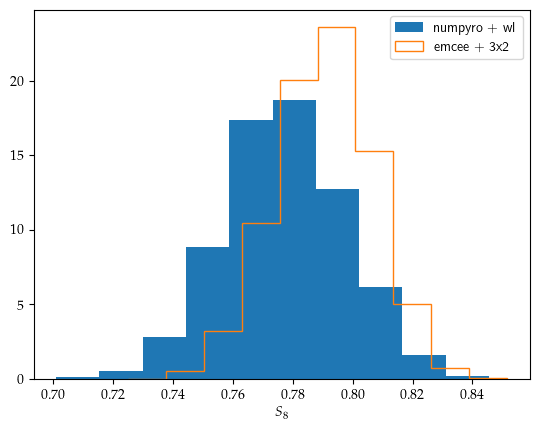

In [107]:
plt.hist(samples_om_s8[:,1], density = True, label = 'numpyro + wl + EH')
plt.hist(samples_om_s8_emcee[:,1], density=True, histtype='step', label = 'emcee + 3x2 + Eh')
plt.xlabel(r'$S_{8}$')
plt.legend()
plt.show()